In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm
import copy

from mbptycho.code.simulation import reloadSimulation, Simulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.recons.recons import PhaseOnlyReconstruction

import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base_path = os.environ['HOME']

In [6]:
strain_type = 'point_inclusion'

In [7]:
probes_3d_h5_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes.h5'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'


In [14]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm = reloadSimulation(sim_data_path, reload_sim=False,
                      reload_sample_only_filename=sample_data_path,
                      save_sample_only_filename=sample_data_path,
                      new_sim_params={'probes_matlab_h5_file':probes_3d_h5_path, 
                                      'n_scan_positions':11,
                                      'npix_scan_shift':9,
                                      'HKL_list':np.array([#[1, 0, 0],
                                                           #[1, 1, 0],
                                                           [1, 2, 0]]),
                                                           #[2, 1, 0]]),
                                     'magnitudes_scaling_per_peak': np.array([0.907052]),#, 0.707052, 
                                                                              #0.5033028, 0.3033028]),
                                     'poisson_noise': False},
                      new_extra_sample_params={'strain_type':strain_type, 
                                               'npix_delta_x':5,
                                               'npix_delta_y':5})

Creating new simulation...
Reloading sample from provided file... /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/apodized_probe_weak_peaks/sample_point_inclusion.pkl
Sample reloaded.
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from h5py file...
Loading successfull...
Saving new simulation at /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/apodized_probe_weak_peaks/sim_point_inclusion.pkl...


In [15]:
sm.ptycho_scan_positions

array([[-45, -45],
       [-45, -36],
       [-45, -27],
       [-45, -18],
       [-45,  -9],
       [-45,   0],
       [-45,   9],
       [-45,  18],
       [-45,  27],
       [-45,  36],
       [-45,  45],
       [-36, -45],
       [-36, -36],
       [-36, -27],
       [-36, -18],
       [-36,  -9],
       [-36,   0],
       [-36,   9],
       [-36,  18],
       [-36,  27],
       [-36,  36],
       [-36,  45],
       [-27, -45],
       [-27, -36],
       [-27, -27],
       [-27, -18],
       [-27,  -9],
       [-27,   0],
       [-27,   9],
       [-27,  18],
       [-27,  27],
       [-27,  36],
       [-27,  45],
       [-18, -45],
       [-18, -36],
       [-18, -27],
       [-18, -18],
       [-18,  -9],
       [-18,   0],
       [-18,   9],
       [-18,  18],
       [-18,  27],
       [-18,  36],
       [-18,  45],
       [ -9, -45],
       [ -9, -36],
       [ -9, -27],
       [ -9, -18],
       [ -9,  -9],
       [ -9,   0],
       [ -9,   9],
       [ -9,  18],
       [ -9,

In [16]:
(25 * 5) // 2

62

In [17]:
(15 * 9) // 2

67

In [18]:
for s in sm.simulations_per_peak:
    print(np.min([d.sum() for d in s.diffraction_patterns]))

222.60059660989722


## Reconstructing the phases/ shared magnitudes

In [20]:
phases_init = []
magnitudes_init = []
for ii in range(1):
    r = sm.rhos[ii]
    r_this = r[...,50][sm.sample.obj_mask_w_delta[...,50]]
    phases_init.append(np.angle(r_this))
    magnitudes_init.append(np.abs(r_this))
phases_init = np.array(phases_init)
magnitudes_init = np.array(magnitudes_init)

In [34]:
recons = PhaseOnlyReconstruction(simulation=sm, shared_magnitudes=True,
                                 batch_size=10, phases_init=phases_init)
                                 #magnitudes_init=magnitudes_init)

Setting background_level to 1e-08...


In [41]:
phases_lr = 1e-3
magnitude_lr = 1e-2
#if not 'phases_v' in recons.optimizers:
#    recons.setPhaseAdamOptimizer(phases_lr)
#else:
#    recons.optimizers['phases_v']['learning_rate'].assign(phases_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

#recons.optimizers

In [42]:
recons.finalizeInit()

Initializing the datalog...


In [43]:
lossvals = []

In [ ]:
for i in range(1000):
    recons._genNewTrainBatch()
    with tf.GradientTape() as gt:
        preds = recons._batch_train_preds_fn(phases_v=recons.fwd_model.phases_v, magnitudes_log_v=recons.fwd_model.magnitudes_log_v)

        loss = recons._train_loss_fn(preds)
    
    if i%10 == 0: print(i, loss)
    
    u_grad, m_grad = gt.gradient(loss, [recons.fwd_model.phases_v, recons.fwd_model.magnitudes_log_v])

    #recons.optimizers['phases_v']['optimizer'].apply_gradients(zip([u_grad], [recons.fwd_model.phases_v]))
    recons.optimizers['magnitudes_log_v']['optimizer'].apply_gradients(zip([m_grad],[recons.fwd_model.magnitudes_log_v]))
    
    lossvals.append(loss)        


0 tf.Tensor(40674.453, shape=(), dtype=float32)
10 tf.Tensor(43913.81, shape=(), dtype=float32)
20 tf.Tensor(44507.555, shape=(), dtype=float32)
30 tf.Tensor(44805.727, shape=(), dtype=float32)
40 tf.Tensor(44901.22, shape=(), dtype=float32)
50 tf.Tensor(43652.098, shape=(), dtype=float32)
60 tf.Tensor(33889.74, shape=(), dtype=float32)
70 tf.Tensor(49041.414, shape=(), dtype=float32)
80 tf.Tensor(42842.258, shape=(), dtype=float32)
90 tf.Tensor(42264.03, shape=(), dtype=float32)
100 tf.Tensor(38843.72, shape=(), dtype=float32)
110 tf.Tensor(47514.746, shape=(), dtype=float32)
120 tf.Tensor(45894.336, shape=(), dtype=float32)
130 tf.Tensor(46100.04, shape=(), dtype=float32)
140 tf.Tensor(41721.9, shape=(), dtype=float32)
150 tf.Tensor(47140.703, shape=(), dtype=float32)
160 tf.Tensor(46763.93, shape=(), dtype=float32)
170 tf.Tensor(39550.992, shape=(), dtype=float32)
180 tf.Tensor(46627.645, shape=(), dtype=float32)
190 tf.Tensor(39766.25, shape=(), dtype=float32)
200 tf.Tensor(55357.5

In [1]:
mags = recons.fwd_model._getMagnitudeNumpyOutput()['magnitudes']
phs = np.angle(recons.fwd_model._getPhaseNumpyOutput()['rho_2d'])

NameError: name 'recons' is not defined

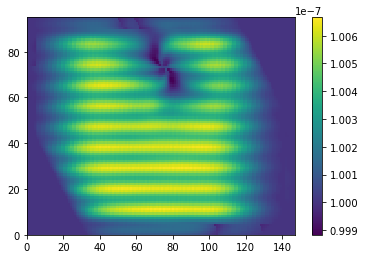

In [40]:
plt.pcolormesh(mags[0])
plt.colorbar()

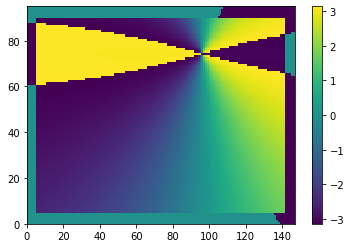

In [131]:
plt.pcolormesh(phs[0])
plt.colorbar()

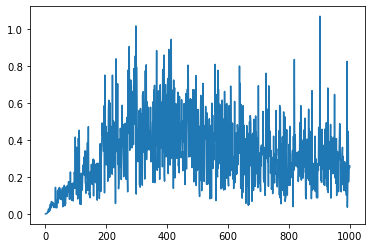

In [132]:
plt.plot(np.array(lossvals))

In [16]:
recons.minimize(1)

Initializing the datalog...


TypeError: in user code:

    /raid/home/skandel/code/mbptycho/mbptycho/code/recons/recons.py:357 optimizersMinimize  *
        preds = self._batch_train_preds_fn(phases_v=self.fwd_model.phases_v,
    /raid/home/skandel/code/mbptycho/mbptycho/code/recons/base.py:213 None  *
        preds_fn = lambda *args, **kwargs: map_preds_fn(self.fwd_model.predict(*args, **kwargs))
    /raid/home/skandel/code/mbptycho/mbptycho/code/recons/forward_model.py:451 predict  *
        return self._batchPredictFromPhasesMagnitudes(batch_input_v, phases_v, magnitudes_log_v)
    /raid/home/skandel/code/mbptycho/mbptycho/code/recons/forward_model.py:456 _batchPredictFromPhasesMagnitudes  *
        proj_map_fn = lambda indx: self._getProjFtT(rho_3d_bordered_all_t, indx)
    /raid/home/skandel/code/mbptycho/mbptycho/code/recons/forward_model.py:296 _getProjFtT  *
        probe_pad = self._scan_probe_pads[bragg_index][scan_coord_index]

    TypeError: list indices must be integers or slices, not Tensor


In [66]:
recons.rho_2d

array([[[1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j, ...,
         1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j],
        [1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j, ...,
         1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j],
        [1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j, ...,
         1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j],
        ...,
        [1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j, ...,
         1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j],
        [1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j, ...,
         1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j],
        [1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j, ...,
         1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j]],

       [[1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j, ...,
         1.0000002e-07+0.j, 1.0000002e-07+0.j, 1.0000002e-07+0.j],
        [1.0000002e

In [51]:
recons.minimize(500)

ValueError: NaN values found, please remove NaNs from your input data or use the `reference_mask`/`moving_mask` keywords, eg: phase_cross_correlation(reference_image, moving_image, reference_mask=~np.isnan(reference_image), moving_mask=~np.isnan(moving_image))

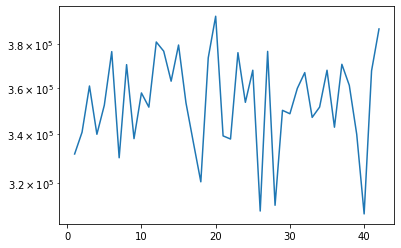

In [76]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [77]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_t

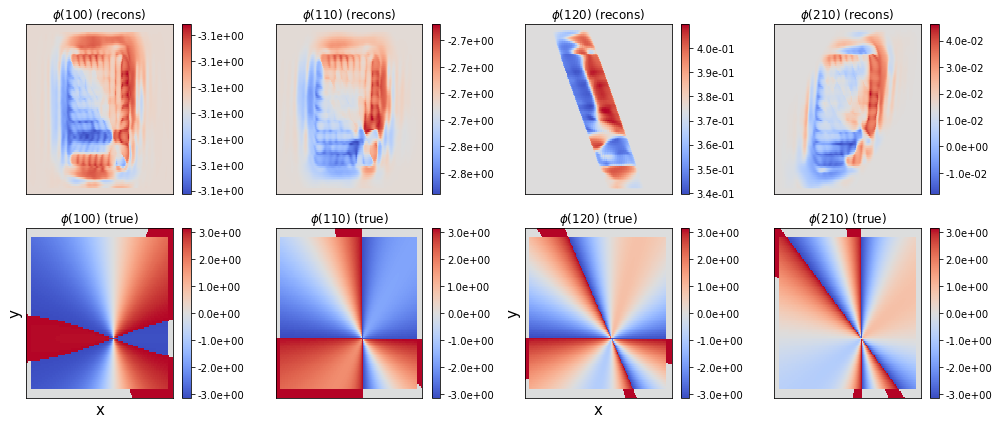

In [78]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

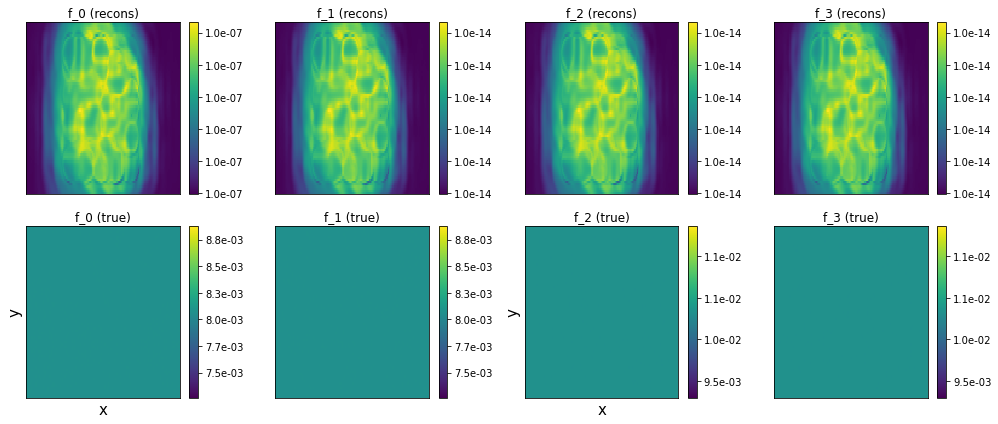

In [60]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][10:-10,10:-10])
    true_amplitudes = np.abs(recons._rho_true[i][10:-10,10:-10])
    
    cp0 = axs[0, i].pcolormesh(recons_amplitudes)
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(true_amplitudes)
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [61]:
recons.saveOutputsAndLog(data_path, prefix='')

rhos saved in /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks//rho_phase_shared_mags.npz
dataframe saved in /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks//df_phase_shared_mags.gz


In [62]:
phases_init = np.angle(recons.rho_2d)
magnitudes_init = np.abs(recons.rho_2d)

## Convert phases to displacements

In [63]:
from mbptycho.code.recons.recons import DisplacementFromPhaseReconstruction

In [64]:
recons2 = DisplacementFromPhaseReconstruction(simulation=sm, phases_init=phases_init)

In [65]:
recons2.minimize()

       epoch     err_ux     err_uy  err_ux_film  err_uy_film
1          1      0.489      0.428       0.0992       0.0809


In [66]:

true_items = {}
recons2_items = {}

if recons2._model_type != 'phase':
    recons2_items[r"$\alpha_x$"] = recons2.ux_2d - recons2.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons2._ux_true - recons2._ux_true.mean() 

    recons2_items[r"$\alpha_y$"] = recons2.uy_2d - recons2.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons2._uy_true - recons2._uy_true.mean()


if not recons2._model_type == 'displacement_to_phase':

    for i in range(recons2.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons2._rho_true[i], recons2.rho_2d[i], upsample_factor=10)
        recons2_items[labelstr] = np.angle(recons2.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons2._rho_true[i])

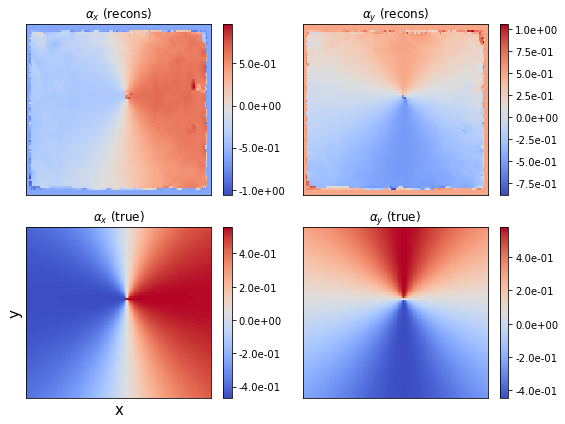

In [67]:
save_plots = False
if recons2._model_type == 'phase':
    subplots_x = recons2.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons2._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons2.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons2._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons2_items.items()):
    if i == 0 and recons2._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons2._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons2._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

In [111]:
recons.saveOutputsAndLog(data_path, prefix='')

In [68]:
ux = recons2_items[r'$\alpha_x$']
uy = recons2_items[r'$\alpha_y$']

In [69]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

In [70]:
sm.sample.params.lattice

array([0.0003905, 0.0003905, 0.0003905])

In [71]:

import matplotlib.colors as colors

<ipython-input-72-0a9d9b3db263>:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,


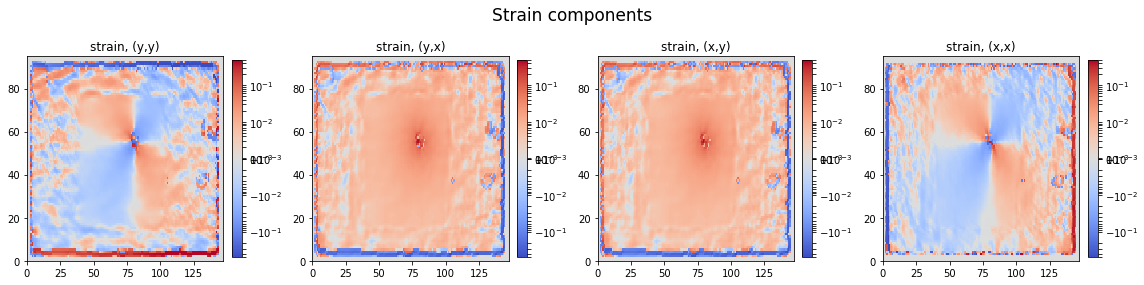

In [72]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.5, vmax=0.5))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  